# Projekti 1: Depolarisoiva kanava
# Ratkaisut

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeGuadalupe
from qiskit_experiments.library.tomography import StateTomography, StateTomographyAnalysis, MitigatedStateTomography, MitigatedTomographyAnalysis
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity

## Tehtävä 1 (1p)

Luo funktio, joka palauttaa kvanttipiirin, joka toteuttaa depolarisoivan kanavan parametrilla $p$ `system`-kubittiin käyttäen kolmea apukubittia `ancillae = [a1, a2, a3]`.

In [2]:
def depolarizing_channel(q, p, system, ancillae):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        p (float): the probability for the channel between 0 and 1
        system (int): index of the system qubit
        ancillae (list): list of indices for the ancillary qubits
        
    Returns:
        A QuantumCircuit object
    """
    
    dc = QuantumCircuit(q)
   
    # 
    theta = 1/2 * np.arccos(1-2*p)
    
    #
    dc.ry(theta, q[ancillae[0]])
    dc.ry(theta, q[ancillae[1]])
    dc.ry(theta, q[ancillae[2]])

    dc.cx(q[ancillae[0]], q[system])
    dc.cy(q[ancillae[1]], q[system])
    dc.cz(q[ancillae[2]], q[system])

    return dc

## Tehtävä 2 (1p)
Luo piiri `prepare_state` joka valmistaa kubitin `system` alkutilaan, jossa populaatiot (?) ja koherenssit poikkeavat nollasta (sekä reaali- että imaginääriosat).

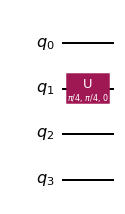

In [3]:
# We create the quantum circuit
q = QuantumRegister(4, name='q')

# Index of the system qubit
system = 1

# Indices of the ancillary qubits
ancillae = [0, 2, 3]

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u(np.pi/4, np.pi/4, 0, q[system])
prepare_state.draw('mpl')

## Tehtävä 3 (4p)
Valmistele tilatomografiakoe, jolla analysoimme piirin ja depolarisoivan kohinan tuottamaa tilaa. Tässä rekonstruoimme tiheysmatriisit ja tilojen [fideliteetit](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states).

1. Eri arvoille $p \in [0, 1]$: 

    1. A) Yhdistä kvanttipiirissä `prepare_state` ja `depolarizing_channel`. 

    2. Valmistele ja aja `StateTomography`, joka löytyy kirjastosta `qiskit_experiments.library.tomography`  tehdäksesi tomografian **vain** `system`-kubitille simulaattoria käyttäen. 

      - Laske myös fideliteetti verrattuna `system`-kubitin tilaan `prepare_state` (eli ilman depolarisoivaa kanavaa). Saatat tarvita toimintoa [`partial_trace`](https://qiskit.org/documentation/apidoc/quantum_info.html#qiskit.quantum_info.partial_trace) `qiskit.quantum_info`:sta. 

      - Laske virherajat fideliteeteille [bootstrapping-menetelmällä](https://en.wikipedia.org/wiki/Bootstrapping_(statistics%29). Käytä tätä varten `StateTomographyAnalysis`-kirjastosta `qiskit_experiments.library.tomography` joillakin argumenteilla ja käytä näitä `StateTomography`:ssa.

    3. Kokoa tiheysmatriisit, fideliteetit ja fideliteettien virheet.
<br/><br/>
2. Kuvaile lyhyesti omin sanoin, mitä `StateTomography` tekee. Mitä täytyy mitata? Miten varmistamme, että tiheysmatriisi on fysiikalinen? (Mahdollisesti hyödyllisiä linkkejä: [Quantum State Tomography](https://qiskit.org/ecosystem/experiments/manuals/verification/state_tomography.html) ja [Open Quantum Systems with Qiskit](https://matteoacrossi.github.io/oqs-jupyterbook/preliminaries.html).) 

In [4]:
# For example, let's consider 10 equally spaced values of p
p_values = np.linspace(0, 1, 10)

# Here we will create a list of circuits for each different value of p
tomography_circuits = []

for p in p_values:
    circ = prepare_state.compose(depolarizing_channel(q, p, system, ancillae))
    tomography_circuits.append(circ)

# Compute fidelities wrt. this state
psi = partial_trace(Statevector(prepare_state), [q for q in range(prepare_state.num_qubits) if q != system])

# Perform boostrapping for fidelity errors
analysis = StateTomographyAnalysis()
analysis.set_options(target_bootstrap_samples=20)

# Now we perform state tomography in simulation and collect the results
backend = AerSimulator()
# backend = FakeGuadalupe()

# backend = AerSimulator(noise_model=noise_model)
rhos = []
fidelities = []
errors = []
for circ in tomography_circuits:
    st = StateTomography(circ, backend=backend, measurement_indices=[system], analysis=analysis, target=psi)
    data = st.run()
    rhos.append(data.analysis_results('state').value)
    fidelities.append(data.analysis_results('state_fidelity').value.n)
    errors.append(data.analysis_results('state_fidelity').value.s)

Quantum state tomography measures the prepared state using a tomographically complete measurement basis. Using the results we can reconstruct the full density matrix of the state. However, using these results directly we may obtain unphysical states, so Qiskit employs maximum-likelihood to find a physical density matrix that maximises the probabilities that match the results. 

## Tehtävä 4 (4p)
1. Find the exact density matrix of the system qubit after the depolarizing channel as a function of $p$ numerically.
2. Plot the values of $\rho_{00}$, $\rho_{11}$, $Re(\rho_{01})$, $Im(\rho_{01})$ as functions of $p$ and compare them to the analytical prediction.
3. Find the exact fidelities of the system qubit after the depolarizing channel as a function of $p$ numerically.
4. Plot both the exact and simulated fidelities of of the system qubit compared to the initial state of the system as a function of $p$. Add the errorbars computed in task 3 to the plots.

Up to the statistical errors due to the finite number of shots, the simulated points should be close to the analytical prediction. For the fidelity, the errorbars cover 1 standard deviation (~68%).

Text(0.5, 1.0, 'SIMULATION Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$')

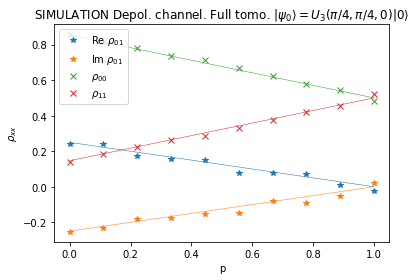

In [15]:
tomo_rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, res) in enumerate(rhos):
    tomo_rhos[:,:,i] = res

# Simulated results
plt.plot(p_values, np.real(tomo_rhos[0,1,:]),"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(tomo_rhos[0,1,:]),"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(tomo_rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(tomo_rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

# Theoretical prediction

# We obtain the density operator of the initial state
rho0 = partial_trace(Statevector(prepare_state), ancillae).data

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend()

plt.title("SIMULATION Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$")

The exact expressions for the density matrix elements for the action of the depolarizing channel follow from the action that is performed on the density matrix. With probability p, the state remains intact, with probability (1-p) the state gets an error. Let us start from the expression of the map given in the project.

$$
\begin{align*}
\mathcal{E} (\rho) &= \left[1-\frac 3 4 p \right] \rho + \frac{p}{4} \sum_i \sigma_i \rho \sigma_i \\
&= \left[1-\frac 3 4 p \right] \rho + \frac{p}{4} (\sigma_x \rho \sigma_x + \sigma_y \rho \sigma_y + \sigma_z \rho \sigma_z) \\
&= \left[1- p \right] \rho + \frac{p}{4} (\sigma_0 \rho \sigma_0 + \sigma_x \rho \sigma_x + \sigma_y \rho \sigma_y + \sigma_z \rho \sigma_z) \\
&= \left[1- p \right] \rho + \frac{p}{4} (2 I) \\
\end{align*}
$$

The last step follows from:
$$
\begin{align*} 
\sigma_0 \rho \sigma_0 + \sigma_x \rho \sigma_x + \sigma_y \rho \sigma_y + \sigma_z \rho \sigma_z&= \begin{bmatrix} \rho_{00} & \rho_{01} \\ \rho_{10} & \rho_{11} \end{bmatrix}+ \sigma_x \begin{bmatrix}  \rho_{00} & \rho_{01} \\ \rho_{10} & \rho_{11} \end{bmatrix} \sigma_x + \sigma_y \begin{bmatrix} \rho_{00} & \rho_{01} \\ \rho_{10} & \rho_{11} \end{bmatrix} \sigma_y + \sigma_z \begin{bmatrix} \rho_{00} & \rho_{01} \\ \rho_{10} & \rho_{11} \end{bmatrix}\sigma_z \\
&= \begin{bmatrix} \rho_{00} & \rho_{01} \\ \rho_{10} & \rho_{11} \end{bmatrix}+\begin{bmatrix} \rho_{11} & \rho_{10} \\ \rho_{01} & \rho_{00} \end{bmatrix}+\begin{bmatrix} \rho_{11} & -\rho_{10} \\ \rho_{01} & \rho_{00} \end{bmatrix} + \begin{bmatrix} \rho_{00} & -\rho_{01} \\ -\rho_{10} & -\rho_{11} \end{bmatrix} \\
&= \begin{bmatrix} 2(\rho_{00} + \rho_{11})  & 0 \\ 0 & 2(\rho_{00} + \rho_{11}) \end{bmatrix} \\
&= 2I
\end{align*}
$$
since for a density matrix $\rho$, $\rho_{00} + \rho_{11}  = \mathrm{Tr}[\rho] = 1$.

Then, you can write the depolarizing channel as:
$$\mathcal{E} (\rho) = (1-p) \rho + p \frac{I}{2}$$
You will most likely see this form more often e.g. on [Wikipedia](https://en.wikipedia.org/wiki/Quantum_depolarizing_channel). For a single-qubit system, they are equivalent.

If we look at the elements of the density matrix after the action of the channel $\rho'$, we get
$$\begin{align*}
\rho'_{00} &=(1-p)\rho_{00} + 0.5p \\
\rho'_{11} &=(1-p)\rho_{11} + 0.5p \\ 
\rho'_{01} &=(1-p)\rho_{01}.
\end{align*}
$$

Text(0.5, 1.0, 'SIMULATION Depol. channel. Fidelity $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$')

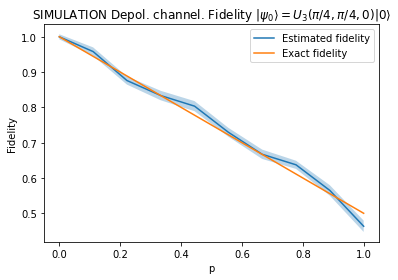

In [16]:
# Simulated results
exact_fidelities = []
for circ in tomography_circuits:
    exact_fidelities.append(state_fidelity(psi, partial_trace(DensityMatrix(circ), ancillae)))

plt.plot(p_values, fidelities, "C0", label="Estimated fidelity")
plt.fill_between(p_values, np.array(fidelities) - np.array(errors), np.array(fidelities) + np.array(errors), alpha=.3)
plt.plot(p_values, exact_fidelities, "C1", label="Exact fidelity")

plt.xlabel('p')
plt.ylabel('Fidelity')
plt.legend()

plt.title("SIMULATION Depol. channel. Fidelity $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$")

## Optional Task
Perform all tasks on a real device with noise mitigation, and compare the results with the simulation. For this you may use [`MitigatedStateTomography`](https://qiskit.org/ecosystem/experiments/stubs/qiskit_experiments.library.tomography.MitigatedStateTomography.html#qiskit_experiments.library.tomography.MitigatedStateTomography) instead of `StateTomography`. Note that `MitigatedTomographyAnalysis` functions a little bit differently from `MitigatedTomographyAnalysis`. Also you may obtain the backend of the real device using the following code (primitives such as the `Sampler` are relatively new, so they are not supported in `qiskit-experiments` yet). Finally, make sure you have created and saved your [IBM Quantum](https://quantum-computing.ibm.com/) account!

In [19]:
# For example, let's consider 10 equally spaced values of p
p_values = np.linspace(0, 1, 10)

# Here we will create a list of circuits for each different value of p
tomography_circuits = []

for p in p_values:
    circ = prepare_state.compose(depolarizing_channel(q, p, system, ancillae))
    tomography_circuits.append(circ)

# Compute fidelities wrt. this state
psi = partial_trace(Statevector(prepare_state), ancillae)

# Perform boostrapping for fidelity errors
state_tomo = StateTomographyAnalysis()
state_tomo.set_options(target_bootstrap_samples=20)

analysis = MitigatedTomographyAnalysis(tomography_analysis=state_tomo)
analysis.set_options(target=psi, unmitigated_fit=True)

# Now we perform state tomography in simulation and collect the results
backend = FakeGuadalupe()

rhos = []
fidelities = []
errors = []

rhos_mit = []
fidelities_mit = []
errors_mit = []

for circ in tomography_circuits:
    st = MitigatedStateTomography(circ, measurement_indices=[system])
    data = st.run(backend=backend, analysis=analysis)
    rhos_mit.append(data.analysis_results('state')[0].value)
    fidelities_mit.append(data.analysis_results('state_fidelity')[0].value.n)
    errors_mit.append(data.analysis_results('state_fidelity')[0].value.s)
    rhos.append(data.analysis_results('state')[1].value)
    fidelities.append(data.analysis_results('state_fidelity')[1].value.n)
    errors.append(data.analysis_results('state_fidelity')[1].value.s)

Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'measure', 'id', 'sx', 'cx']>)) that is different than the current backend (fake_guadalupe). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'measure', 'id', 'sx', 'cx']>)) that is different than the current backend (fake_guadalupe). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'measure', 'id', 'sx', 'cx']>)) that is different than the current backend (fake_guadalupe). The new backend will be used, but service is not changed if one already exists.
Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'measure', 'id', 'sx', 'cx']>

Text(0.5, 1.0, 'SIMULATION Depol. channel. Full tomo. Noisy. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$')

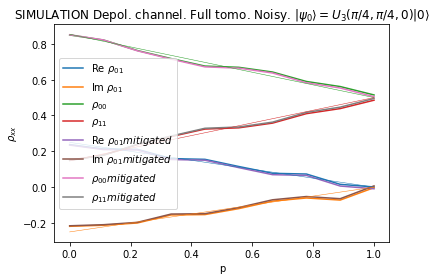

In [20]:
tomo_rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, res) in enumerate(rhos):
    tomo_rhos[:,:,i] = res

tomo_rhos_mit = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, res) in enumerate(rhos_mit):
    tomo_rhos_mit[:,:,i] = res

# Simulated results
plt.plot(p_values, np.real(tomo_rhos[0,1,:]), label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(tomo_rhos[0,1,:]), label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(tomo_rhos[0,0,:]), label='$\\rho_{00}$')
plt.plot(p_values, np.real(tomo_rhos[1,1,:]), label='$\\rho_{11}$')

plt.plot(p_values, np.real(tomo_rhos_mit[0,1,:]),label='Re $\\rho_{01} mitigated$')
plt.plot(p_values, np.imag(tomo_rhos_mit[0,1,:]), label='Im $\\rho_{01} mitigated$')
plt.plot(p_values, np.real(tomo_rhos_mit[0,0,:]), label='$\\rho_{00} mitigated$')
plt.plot(p_values, np.real(tomo_rhos_mit[1,1,:]), label='$\\rho_{11} mitigated$')

# Theoretical prediction

# We obtain the density operator of the initial state
rho0 = partial_trace(Statevector(prepare_state), ancillae).data

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend()

plt.title("SIMULATION Depol. channel. Full tomo. Noisy. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$")

Text(0.5, 1.0, 'SIMULATION Depol. channel. Fidelity. Mitigated. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$')

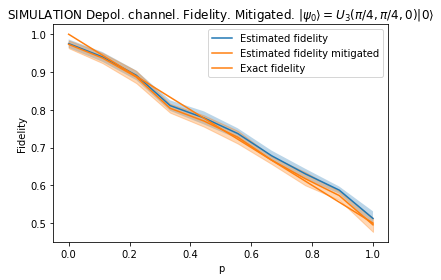

In [22]:
# Simulated results
exact_fidelities = []
for circ in tomography_circuits:
    exact_fidelities.append(state_fidelity(psi, partial_trace(DensityMatrix(circ), ancillae)))

plt.plot(p_values, fidelities, "C0", label="Estimated fidelity")
plt.fill_between(p_values, np.array(fidelities) - np.array(errors), np.array(fidelities) + np.array(errors), alpha=.3)
plt.plot(p_values, fidelities_mit, color="tab:orange", label="Estimated fidelity mitigated")
plt.fill_between(p_values, np.array(fidelities_mit) - np.array(errors_mit), np.array(fidelities_mit) + np.array(errors_mit), color="tab:orange", alpha=.3)
plt.plot(p_values, exact_fidelities, "C1", label="Exact fidelity")

plt.xlabel('p')
plt.ylabel('Fidelity')
plt.legend()

plt.title("SIMULATION Depol. channel. Fidelity. Mitigated. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$")

While the readout error mitigation help a little, we see that the results still don't match the expected fidelities, which is why there must be other sources of error!